In [6]:
import numpy as np
# Train a model to classify real pulses vs. noise
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import awkward as ak
from tensorflow.keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras import layers
#from focal_loss import BinaryFocalLoss
import uproot
print(uproot.__version__)

4.3.7


In [7]:
np.random.seed(42)  # For reproducibility
num_samples = 10
xmin = 0
xmax = 10

In [8]:
def plot_timesamples(ax, time, emsignal_list, noisedata_list):
    #fig, ax = plt.subplots()
    for i, emsignal in enumerate(emsignal_list):
        noisedata = noisedata_list[i]
        ax.plot(time, emsignal, label=f'EM pulse' if i==1 else None, color='blue')
        ax.plot(time, noisedata, label=f'noise'  if i==1 else None,color='orange')
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Amplitude (arb. units)')
    ax.legend()

[{samples: [0.069, 0.106, -0.0914, 0.0191, 0.857, 1, ... 1], ysamplesNoise: [0]}]
[[ 0.06895913  0.1056133  -0.09143379 ... -0.42161528 -0.29712962
  -0.58216445]
 [ 0.34485138 -0.08731802  0.06661344 ...  0.77302449  0.04550623
   0.00307311]
 [ 0.1237994   0.15758994  0.23702709 ...  0.74946809  0.89637208
   1.        ]
 ...
 [ 1.          0.62787424  0.57464587 ...  0.41968943  0.39734582
   0.42379536]
 [-0.65117343 -0.57384061 -0.45669995 ...  1.          0.87509126
   0.38797116]
 [ 0.21053889  0.16166221  0.15492851 ...  0.832201    0.76484686
   0.86871617]]
Printing y_real
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


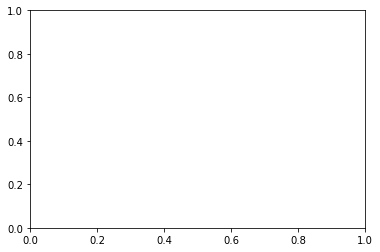

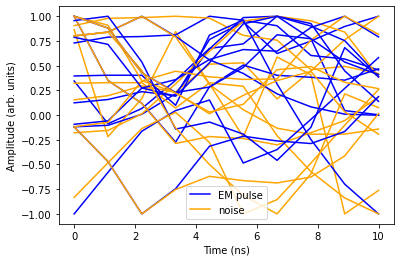

In [9]:
# Generate a dataset of real pulses
#dirName = "noise_0p06/1GeV/"
#dirName = "noise_0p15/1GeV/"
#dirName = "noise_0p15/0p2GeV/"
dirName = "noise_0p15/0p15GeV/"  ### used this with PU for training


#root_file = uproot.open(f"/eos/user/s/shilpi/SWAN_projects/ECAL_noise_EM_discrimination/data/{dirName}/outputPSWithoutPU_withNoise.root")
root_file = uproot.open(f"/eos/user/s/shilpi/SWAN_projects/ECAL_noise_EM_discrimination/data/{dirName}/outputPSWithPU_withNoise.root")


# Access the tree containing the data
tree = root_file["Samples"]

# Read the needed branches into numpy arrays
### returns the data from a TTree branch in the form of a dictionary 
### where keys are the names of the branches and values are NumPy arrays containing the data.
arrays = tree.arrays(["samples", "ysamples","samplesNoise","ysamplesNoise" ])
print(arrays)

# Read the "sample" and "sampleNoise" branches into numpy arrays
X_real = ak.to_numpy(arrays["samples"])
y_real = ak.to_numpy(arrays["ysamples"])
X_noise = ak.to_numpy(arrays["samplesNoise"])
y_noise = ak.to_numpy(arrays["ysamplesNoise"])

print(X_real) 
print("Printing y_real")
print(y_real)

data = np.concatenate([X_real, X_noise]) ### makes it [2*num_events,num_samples]
labels = np.concatenate([y_real,y_noise])


# Shuffle data and labels together
## Important to shuffle since I take some fraction of events so it should not happen that all the real events 
## are cluttered at the beginning
shuffle_indices = np.random.permutation(len(data))
data = data[shuffle_indices]
labels = labels[shuffle_indices]

###plot 
fig, ax = plt.subplots()

'''
#ev_number = 4
ev_number = 100
ax = plot_timesamples(ax, t_events[ev_number], X_real[ev_number],X_noise[ev_number]) ###eventnumber
ev_number = 4
ax = plot_timesamples(ax, t_events[ev_number], X_real[ev_number],X_noise[ev_number]) ###eventnumber
'''

import awkward as ak

num_events = ak.num(X_real, axis=0)

###replace this block with actual time variable

t_events = np.zeros((num_events, num_samples))
for i in range(num_events):
    t_event = np.linspace(xmin, xmax, num_samples)
    t_events[i] = t_event
###replace this block with actual time variable

fig, ax = plt.subplots()
ev_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9 , 10, 100, 200, 300]  # list of event numbers to plot
emsignal_list = [X_real[ev_number] for ev_number in ev_numbers]
noisedata_list = [X_noise[ev_number] for ev_number in ev_numbers]
plot_timesamples(ax, t_events[ev_numbers[0]], emsignal_list, noisedata_list)
plt.show()

In [ ]:

import awkward as ak


num_events_data = ak.num(data, axis=0)
print(f'number of rows in data is {num_events_data}')


ntimeSamples_data = ak.num(data, axis=1) ### elements within each sub-array:
print(f'number of time samples in data is {ntimeSamples_data[0]}') ## just take the 0th event

# Split into train and test sets
train_size = int(0.7 * num_events_data) ###
train_data = data[:train_size]
train_labels = labels[:train_size]
test_data = data[train_size:]
test_labels = labels[train_size:]

print(f'Size of training data is {train_size}')

print(f'number of elements in data : training data : test data : {len(data)} : {len(train_data)} : {len(test_data)}')


# Define RNN model
inputs = Input(shape=(ntimeSamples_data[0], 1)) #### 3rd dim is the vectorial rep of one element of time series data

### Used for first presentation

### LSTM Bidirectional model with one more LSTM layer + sigmoid
inputs = (ntimeSamples_data[0], 1)
model = keras.Sequential()
model.add(layers.Bidirectional(layers.LSTM(64, activation='relu', return_sequences=True), input_shape=(ntimeSamples_data[0], 1)))
model.add(layers.Bidirectional(layers.LSTM(32, activation='relu')))
model.add(layers.Dense(1, activation='sigmoid'))

### stopping criteria
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) ## metric is just printing
#model.compile(optimizer='adam', loss='hinge', metrics=['accuracy'])

# Define the EarlyStopping callback
### restore_best_weights: If True, the model weights from the epoch with the best 
####validation loss will be restored after training is stopped.
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, restore_best_weights=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, min_delta=0.01, restore_best_weights=True)

#history = model.fit(train_data[..., np.newaxis], train_labels, epochs=1, batch_size=32, validation_split=0.2
history = model.fit(train_data[..., np.newaxis], train_labels,  epochs=100, batch_size=32, validation_split=0.2
                   ,callbacks=[early_stopping])
model.summary()


### save the model
# Save the model to a file
model.save('/eos/user/s/shilpi/SWAN_projects/ECAL_noise_EM_discrimination/model/timeSeries_model.h5')

# Evaluate model
test_loss, test_acc = model.evaluate(test_data[..., np.newaxis], test_labels)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')


number of rows in data is 200000
number of time samples in data is 10
Size of training data is 140000
number of elements in data : training data : test data : 200000 : 140000 : 60000
Epoch 1/100
3500/3500 [==============================] - 64s 17ms/step - loss: 0.5584 - accuracy: 0.7131 - val_loss: 0.5174 - val_accuracy: 0.7512
Epoch 2/100
3500/3500 [==============================] - 58s 17ms/step - loss: 0.5075 - accuracy: 0.7574 - val_loss: 0.5009 - val_accuracy: 0.7631
Epoch 3/100
3500/3500 [==============================] - 59s 17ms/step - loss: 0.5045 - accuracy: 0.7588 - val_loss: 0.5025 - val_accuracy: 0.7601
Epoch 4/100
3500/3500 [==============================] - 59s 17ms/step - loss: 0.5017 - accuracy: 0.7614 - val_loss: 0.4948 - val_accuracy: 0.7651
Epoch 5/100
3500/3500 [==============================] - 59s 17ms/step - loss: 0.4997 - accuracy: 0.7627 - val_loss: 0.4963 - val_accuracy: 0.7660
Epoch 6/100
3500/3500 [==============================] - 59s 17ms/step - loss: 0.4

In [ ]:
print(len(history.history['loss']))

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



In [ ]:
from sklearn.metrics import confusion_matrix

# Make predictions on test data
predictions = model.predict(test_data[..., np.newaxis]).flatten()

### for confusion matrix
#predictions_unflat = model.predict(test_data[..., np.newaxis])
#print(predictions_unflat)
#Create confusion matrix and normalizes it over predicted (columns)
#y_prediction = np.argmax(predictions_unflat, axis = 1)
y_predictions = (predictions > 0.5).astype(int)
y_test=np.argmax(test_labels, axis=1)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print("Confusion matrix is")
print(result)


# Convert predictions to binary labels
binary_predictions = (predictions > 0.5).astype(int)

print(f'{len(test_labels)} and {len(binary_predictions)}')
print(f" predictions are {predictions}")
# Create scatter plot of true labels vs. predicted labels
plt.scatter(test_labels, predictions, alpha=0.1)
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('True Labels vs. Predicted Labels')
plt.show()


'''
#### other way to predict - loop over all
nev=0
for iev in test_data:
    #print(f"iev is {iev} and shape is {iev.shape}")
    input_sample = np.reshape(iev, (1, iev.shape[0], 1))
    bdt_score = model.predict(input_sample)  
    print(f"BDT score is {bdt_score}")
    nev = nev + 1
'''

In [ ]:
###plot the score

print(f'test labels are: {test_labels[:,0]}')

# Create separate arrays for background and signal predictions
bkg_preds = predictions[test_labels[:,0] == 0]
sig_preds = predictions[test_labels[:,0] == 1]

print(bkg_preds)
print(sig_preds)
# Plot the predicted probabilities
plt.hist(bkg_preds, bins=50, label='Background', alpha=0.5, density=True)
plt.hist(sig_preds, bins=50, label='Signal', alpha=0.5, density=True, color='green')
plt.xlabel('Predicted Probability')
plt.ylabel('Number of Events')
plt.legend(loc='upper center')
#plt.ylim(top=100)
plt.show()



In [ ]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.xlim([0.9, 1])
#plt.ylim([0.999, 1.005])
plt.show()

In [ ]:
### precision recall curve
# Calculate precision-recall curve and average precision
precision, recall, _ = precision_recall_curve(test_labels, predictions)
average_precision = average_precision_score(test_labels, predictions)

# Plot precision-recall curve
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()